# Custom operations

## The `tf.data` pipeline in multi-backend

Keras 3 enables a multi-backend behavior, by internally calling `tensorflow`, `torch` or `jax` functions, depending on the `KERAS_BACKEND` environment variable. It also enables training models with different data loaders, such as the `tf.data` pipeline, no matter the backend used ! Unfortunately, this is not well supported in practice, because it would require duplicating the functions in the keras multi-backend functions + in pure tensorflow, to be compatible with `tf.data`. 

To demonstrate this issue, the next cell defines a simple image normalization function with the `torch` backend, in a `tf.data` pipeline. In contrast, a second `tf_normalize_image` is defined to work with the `tf.data`. Nonetheless, it is weird to have both functions implemented for every processing functions...

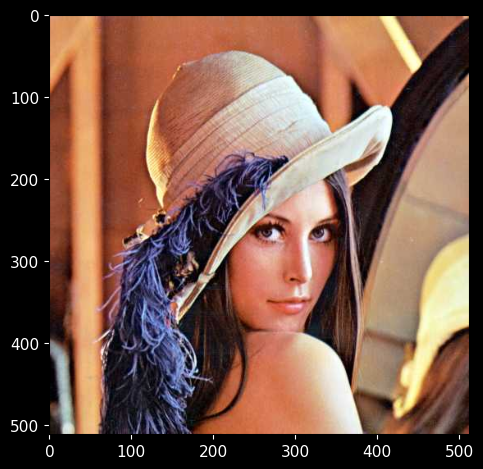

An (expected) error occured : in user code:

    File "/tmp/ipykernel_1956/4185650824.py", line 12, in normalize_image  *
        image = K.convert_to_tensor(image)
    File "~/lib/python3.10/site-packages/keras/src/ops/core.py", line 917, in convert_to_tensor  **
        return backend.convert_to_tensor(x, dtype=dtype, sparse=sparse)
    File "~/lib/python3.10/site-packages/keras/src/backend/torch/core.py", line 218, in convert_to_tensor
        x = np.array(x)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (args_0:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.

<_MapDataset element_spec=TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None)>


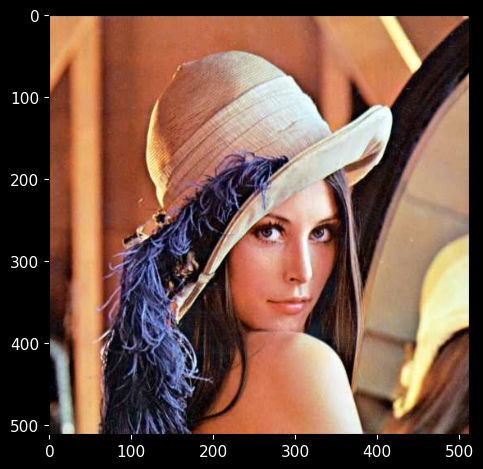

2024-10-31 08:07:06.453489: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [2]:
import os

os.environ['KERAS_BACKEND'] = 'torch'

import keras.ops as K
import tensorflow as tf

from utils import plot
from utils.image import load_image

def normalize_image(image):
    image = K.convert_to_tensor(image)
    image = image - K.min(image)
    return K.divide_no_nan(image, K.max(image))

def tf_normalize_image(image):
    image = image - tf.reduce_min(image)
    return tf.math.divide_no_nan(image, tf.reduce_max(image))

filename = 'example_data/images/lena.jpg'

plot(K.convert_to_numpy(normalize_image(load_image(filename))))

try:
    pipeline = tf.data.Dataset.from_tensor_slices([filename]).map(load_image).map(normalize_image)
    print(pipeline)
    for image in pipeline:
        plot(image)
except Exception as e:
    print('An (expected) error occured : {}'.format(str(e)))


pipeline = tf.data.Dataset.from_tensor_slices([filename]).map(load_image).map(tf_normalize_image)
print(pipeline)
for image in pipeline:
    plot(image)


## The `utils.keras_utils.ops` module, and the `build_op` function

To solve the previous limitation, the custom operations built with the `build_op` function will leverages the `tensorflow` function when executed in `tensorflow graph` mode (e.g., in a `tf.data` pipeline), and the `keras.ops` function otherwise !

Here is a simplified version of `build_op`, to demonstrate the behavior :
```python
def build_op(k_op, tf_op = None):
    if tf_op is None: tf_op = k_op
    
    keras_fn    = getattr(K, k_op) if isinstance(k_op, str) else k_op
    tf_fn       = getattr(tf, tf_op) if isinstance(tf_op, str) else tf_op
    
    if tf_fn is None:
        logger.debug('`{}` does not exist in tensorflow, using `keras.ops`'.format(tf_op))
        tf_fn = keras_fn
    
    def ops(* args, allow_np = True, ** kwargs):
        if not tf.executing_eagerly():
            return tf_fn(* args, ** kwargs)
        return keras_fn(* args, ** kwargs)
    
    ops.__name__ = keras_fn.__name__
    ops.__doc__  = keras_fn.__doc__
    return ops

min = reduce_min = build_op('min', 'reduce_min')
max = reduce_max = build_op('max', 'reduce_max')

```

The below cell re-implements the `normalize_image` by leveraging the custom operations, and now the same function is working both in `pytorch` backend **and** in `tf.data` pipeline ! Furthermore, the `keras_utils.ops` redefines all the operations with the `keras` names as well as the `tensorflow` names (e.g., `keras.ops.max` == `tf.reduce_max`) ! This allows to not have to convert every tensorflow code into the `keras` names

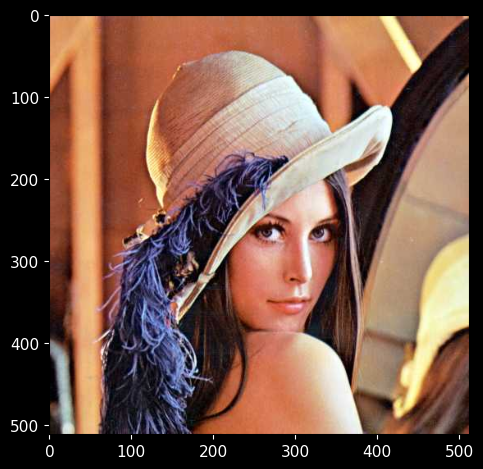

<_MapDataset element_spec=TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None)>


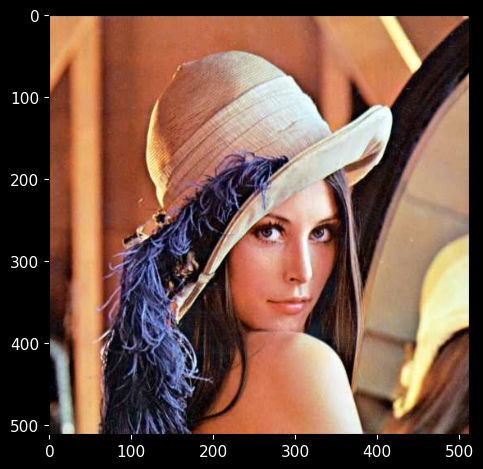

In [3]:
import os

os.environ['KERAS_BACKEND'] = 'torch'

import tensorflow as tf

from utils import plot
from utils.keras_utils import ops
from utils.image import load_image

def normalize_image(image):
    image = ops.convert_to_tensor(image)
    image = image - ops.min(image)
    return ops.divide_no_nan(image, ops.max(image))

filename = 'example_data/images/lena.jpg'

plot(K.convert_to_numpy(normalize_image(load_image(filename))))

pipeline = tf.data.Dataset.from_tensor_slices([filename]).map(load_image).map(normalize_image)
print(pipeline)
for image in pipeline:
    plot(image)


## The `build_op` and the `numpy` backend

Based on the above discussion, it is now possible to define custom behaviors for every function ! This has enabled the implementation of an additional backend : `numpy` !

It may seems strange to re-implement everything in numpy while using Deep Learning frameworks like `keras`, which enables faster execution on `GPU`... Nevertheless, in the case of processing / simple computation functions, it is quite useful to leverage the numpy optimisations !

Let's take a simple concrete example for object detection : the `Intersection over Union (IoU)` algorithm between all pairs of boxes (i.e., quadratic complexity). This method is largely used in object detection to filter out overlapping boxes based on their IoU. Let's now benchmark the function in `torch`, and in `numpy` with different input shapes !

The plot demonstrates the benefit of GPU parallelization, mitigating the quadratic complexity of the function. Nonetheless, it is worth mentionning that `numpy` is 5x faster for few boxes commputation ! In practice, after score-based filtering, it is quite common to only have less than 100 boxes to compare in `YOLO` model outputs. In this case, if performance is critical, it may be a great option to consider leveraging `numpy` instead of `keras` ;) Another benefit is that `numpy` leverages CPU `RAM`, which may be interesting when your GPU do not have enough memory to compute the entire pipeline (i.e., pre-processing + model + post-processing)

The test has been done with an `RTX 3090 Ti`, the difference can be even larger depending on your `GPU` 

Time for 4 boxes	: numpy = 149 μs - keras = 464 μs
Time for 8 boxes	: numpy = 90 μs - keras = 297 μs
Time for 16 boxes	: numpy = 87 μs - keras = 298 μs
Time for 32 boxes	: numpy = 92 μs - keras = 296 μs
Time for 64 boxes	: numpy = 106 μs - keras = 297 μs
Time for 128 boxes	: numpy = 164 μs - keras = 299 μs
Time for 256 boxes	: numpy = 380 μs - keras = 296 μs
Time for 512 boxes	: numpy = 2.543 ms - keras = 304 μs


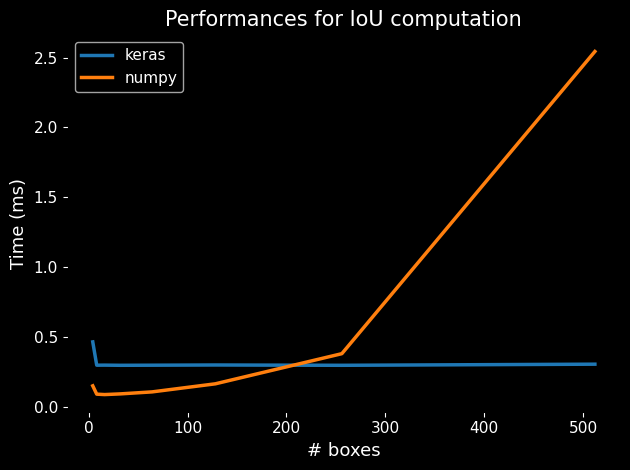

In [4]:
import os
import time

os.environ['KERAS_BACKEND'] = 'torch'

import numpy as np

from utils import plot, time_to_string
from utils.keras_utils import ops
from utils.image.bounding_box import compute_iou


def benchmark(fn, n_repeat = 100):
    t0 = time.time()
    for _ in range(n_repeat):
        x = ops.zeros(())
        fn()
        ops.convert_to_numpy(x)
    return (time.time() - t0) / n_repeat

x, times = [], {'keras' : [], 'numpy' : []}
for i in range(2, 10):
    n = 2 ** i
    xy = np.random.uniform(0., 1., size = (n, 2))
    boxes = np.concatenate([xy, xy + 0.5], axis = 1)
    k_boxes = ops.convert_to_tensor(boxes)
    
    np_time = benchmark(lambda: compute_iou(boxes, as_matrix = True, source = 'xyxy'))
    k_time  = benchmark(lambda: compute_iou(k_boxes, as_matrix = True, source = 'xyxy'))

    print('Time for {} boxes\t: numpy = {} - keras = {}'.format(n, time_to_string(np_time), time_to_string(k_time)))
    x.append(n)
    times['keras'].append(k_time * 1000)
    times['numpy'].append(np_time * 1000)

plot(x, times, title = 'Performances for IoU computation', xlabel = '# boxes', ylabel = 'Time (ms)')

Time for 4 boxes	: numpy = 318 μs - keras = 1.236 ms
Time for 8 boxes	: numpy = 231 μs - keras = 1.225 ms
Time for 16 boxes	: numpy = 233 μs - keras = 1.227 ms
Time for 32 boxes	: numpy = 239 μs - keras = 1.220 ms
Time for 64 boxes	: numpy = 253 μs - keras = 1.223 ms
Time for 128 boxes	: numpy = 312 μs - keras = 1.223 ms
Time for 256 boxes	: numpy = 531 μs - keras = 1.229 ms
Time for 512 boxes	: numpy = 2.389 ms - keras = 1.249 ms


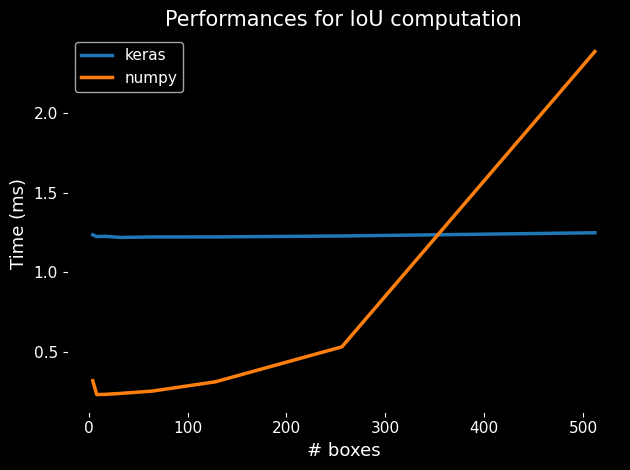

In [2]:
import os
import time

os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np

from utils import plot, time_to_string
from utils.keras_utils import ops
from utils.image.bounding_box import compute_iou

def benchmark(fn, n_repeat = 100):
    t0 = time.time()
    for _ in range(n_repeat):
        x = ops.zeros(())
        fn()
        ops.convert_to_numpy(x)
    return (time.time() - t0) / n_repeat

x, times = [], {'keras' : [], 'numpy' : []}
for i in range(2, 10):
    n = 2 ** i
    xy = np.random.uniform(0., 1., size = (n, 2))
    boxes = np.concatenate([xy, xy + 0.5], axis = 1)
    k_boxes = ops.convert_to_tensor(boxes)
    
    np_time = benchmark(lambda: compute_iou(boxes, as_matrix = True, source = 'xyxy'))
    k_time  = benchmark(lambda: compute_iou(k_boxes, as_matrix = True, source = 'xyxy'))

    print('Time for {} boxes\t: numpy = {} - keras = {}'.format(n, time_to_string(np_time), time_to_string(k_time)))
    x.append(n)
    times['keras'].append(k_time * 1000)
    times['numpy'].append(np_time * 1000)

plot(x, times, title = 'Performances for IoU computation', xlabel = '# boxes', ylabel = 'Time (ms)')